In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, Bidirectional, LSTM, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [2]:
df = pd.read_csv("/home/jose/Programming/aiml/Data/houston-AQI-weather/filled-in-data/Oyster Creek C1607.csv")
df['Date'] = pd.to_datetime(df['Date'])
del df['Unnamed: 0']

df.tail()

,Date,AQI,air_temp,dew_point_temp,sea_level_pressure,visibility,wind_speed
1515,2021-02-24,39,20.0,16.0,1018.0,10000.0,4.3750
1516,2021-02-25,30,20.0,17.0,1019.0,9000.0,5.0000
1517,2021-02-26,27,21.0,18.0,1014.0,10000.0,5.3125
1518,2021-02-27,29,22.0,19.0,1013.0,10000.0,5.9375
1519,2021-02-28,29,23.0,19.0,1013.0,10000.0,5.0000


In [3]:
df['Day'] = df.Date.dt.dayofyear
df['Year'] = df.Date.dt.year - 2017
df.index = df.Date


In [4]:
### DELETE all the other features, for now
del df['Date']
del df['air_temp']
del df['dew_point_temp']
del df['sea_level_pressure']
del df['visibility']
del df['wind_speed']

df.tail()

,AQI,Day,Year
Date,,,
2021-02-24,39,55,4
2021-02-25,30,56,4
2021-02-26,27,57,4
2021-02-27,29,58,4
2021-02-28,29,59,4


In [5]:
num_x_signals = 2
num_y_signals = 1

In [6]:
num_train = int(0.9 * len(df))

x = df[['Day', 'Year']].values
y = df.AQI.values

x_train = x[:num_train]
y_train = np.expand_dims(y[:num_train], axis=1) # Give the extra 1 at the end
x_test = x[num_train:]
y_test = np.expand_dims(y[num_train:], axis=1)

print(x_train.shape)
print(y_train.shape)

(1368, 2)
(1368, 1)


In [7]:
y_scaler = MinMaxScaler()

# Don't need to scale x (just dates as features)
x_train_scaled = x_train
x_test_scaled = x_test

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [8]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [9]:
generator = batch_generator(batch_size=128, sequence_length=7 * 8)


x_batch, y_batch = next(generator)

In [10]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [26]:
model = Sequential()
model.add(Bidirectional(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,))))

model.add(Dropout(0.2))

model.add(GRU(units=256,
              return_sequences=True))

model.add(Dropout(0.2))

model.add(Dense(num_y_signals, activation='sigmoid'))

In [12]:
warmup_steps = 15
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [28]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [27]:
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [15]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 849us/step - loss: 0.0066


In [16]:


def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(1):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.legend()
        plt.show()



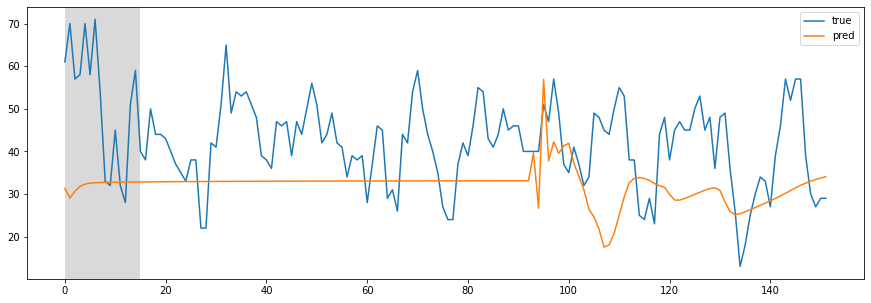

In [19]:
plot_comparison(start_idx=0, length=950, train=False)

In [38]:
df.tail()

,AQI,Day,Year
Date,,,
2021-02-24,39,55,4
2021-02-25,30,56,4
2021-02-26,27,57,4
2021-02-27,29,58,4
2021-02-28,29,59,4


In [78]:
predict_days = [[60, 4], # 60th day of the 4th year (2021)
                [61, 4], # March 2 2021
                [62, 4], # Marh 3 2021
                [63, 4],
                [64, 4],
                [65, 4],
                [66, 4]] 

# Expand dimensions to fit in input shape (accomodate for first dim - batch size)
predict_days = np.expand_dims(predict_days, axis=0)


In [79]:
forecast = model.predict(predict_days)

# np.squeeze to delete first dim
forecast_AQI = y_scaler.inverse_transform(np.squeeze(forecast, axis=0))

print(forecast_AQI)


[[56.885517]
 [44.51422 ]
 [42.780632]
 [50.990494]
 [49.671265]
 [47.225437]
 [45.512135]]
